In [1]:
from google.colab import files
uploaded = files.upload()

Saving retail_sales_dataset_indian_names.xlsx to retail_sales_dataset_indian_names.xlsx


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import joblib

In [ ]:
df = pd.read_excel("retail_sales_dataset_indian_names.xlsx")

In [ ]:
def load_and_aggregate(excel_file):
    df = pd.read_excel(excel_file, sheet_name = "transactions")
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    daily = df.groupby(df['transaction_date'].dt.date)['quantity'].sum().reset_index()
    daily.columns = ['date', 'total_quantity']
    daily['date'] = pd.to_datetime(daily['date'])
    full_dates = pd.DataFrame({'date': pd.date_range(daily['date'].min(), daily['date'].max())})
    daily = full_dates.merge(daily, on ='date', how = 'left').fillna(0)
    return daily

excel_path = "retail_sales_dataset_indian_names.xlsx"
daily = load_and_aggregate(excel_path)

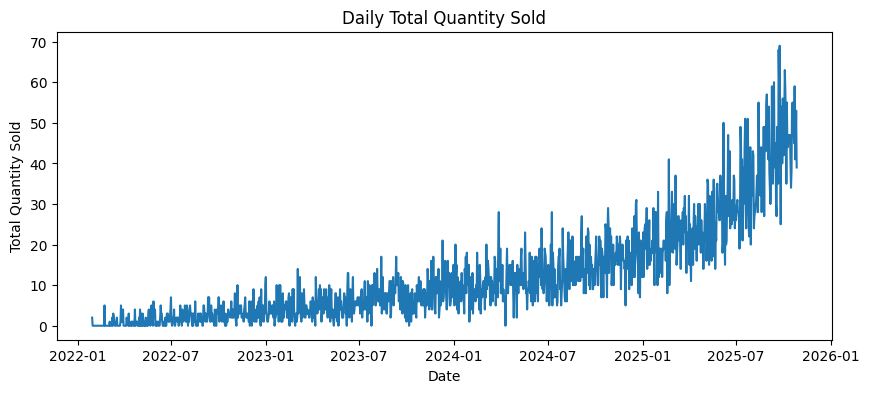

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the 'transactions' sheet from the excel file
df = pd.read_excel("retail_sales_dataset_indian_names.xlsx", sheet_name='transactions')

# Plot the daily total quantity
plt.figure(figsize=(10,4))
plt.plot(daily['date'], daily['total_quantity'])
plt.title("Daily Total Quantity Sold")
plt.xlabel("Date")
plt.ylabel("Total Quantity Sold")
plt.show()

In [ ]:
def create_sequences( values, window = 30):
    X,y = [], []
    for i in range(len(values) - window):
        X.append(values[i:i+window])
        y.append(values[i + window])
    return np.array(X), np.array(y)

In [ ]:
#convert to numpy series
series = daily['total_quantity'].values.astype('float32')
window_size = 30
X, y = create_sequences(series, window_size)

print(f" Created {len(X)} sequences for training")

split = len(X) - 60
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,1))
X_train_scaled = scaler.transform(X_train.reshape(-1,1)).reshape(X_train.shape[0], X_train.shape[1],1)
X_test_scaled = scaler.transform(X_test.reshape(-1,1)).reshape(X_test.shape[0], X_test.shape[1],1)
y_train_scaled = scaler.transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1,1)).flatten()

model = keras.Sequential([
    layers.Input(shape=(window_size, 1)),
    layers.LSTM(64, return_sequences = False),
    layers.Dense(32, activation ='relu'),
    layers.Dense(1)
])

model.compile(optimizer ='adam', loss = 'mse')
model.summary()

 Created 1338 sequences for training


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)